1353.3834586466169


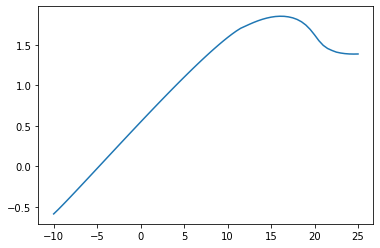

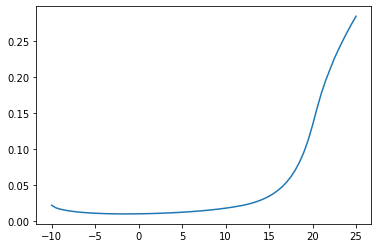

In [357]:
# %% [markdown]
# This is the code group etc...

# %%
import matplotlib.pyplot as plt
import numpy as np
import math


J = 1.9
# %% [markdown]
# first load in some properties of the propeller.

# %%
R = 0.7  # m
n_blades = 6.
U0 = 60.  # m/s
#rpm = 1200.
altitude = 2000  # m
free_stream_incidence_angle = 0
yaw_angle = 15*(np.pi/180)  #Added this for the Yaw angle and changed it to rads
start_blade = 0.25  # r/R
collective_blade_pitch = 46  # degrees at r/R = 0.7
delta_r_R = 0.01
P_s = 79380 #static pressure at 2000 m
spinner_lenght_r_R = 0.25
a = 0.3
a_line = 0
iterations = 100
Erroriterations = 0.0001
density = 1.2250


# %% [markdown]
# Now some calculated constants will be introduced:
rpm = (U0 / (J * 2 * R)) * 60
print(rpm)


# %%
r_R = np.arange(spinner_lenght_r_R, 1 + delta_r_R / 2, delta_r_R) # tot 1.005??????


def twist_fun(r_R_considered):
    twist = -50 * (r_R_considered) + 35 + collective_blade_pitch
    return twist


def chord_fun(r_R_considered):
    chord = 0.18 - 0.06 * (r_R_considered)
    return chord


# %% [markdown]
# Load the 2D airfoil characteristics

# %%
airfoil = "ARAD8pct_polar.txt"
characteristics = np.loadtxt(airfoil, skiprows=2)
alpha_polar = characteristics[:, 0]
cl_polar = characteristics[:, 1]
cd_polar = characteristics[:, 2]

plt.plot(alpha_polar, cl_polar)
plt.show()
plt.plot(alpha_polar, cd_polar)
plt.show()


# %% [markdown]
# defining the loads on the blade element

# %%

def rotational_velocity_func(rpm, r_R_considered, R = R):
    return rpm * r_R_considered* R * 2 * np.pi / 60

In [358]:
def loading_on_blade_element(urotor, utan, r_R_considered, twist, density, chord, alpha_polar, cl_polar, cd_polar):
    inflow_angle = math.atan(urotor / utan)
    w_square = urotor**2 + utan**2
    alpha =  twist - inflow_angle * 180 / np.pi  # plus or minus?????? inflow - twist
    cl = np.interp(alpha, alpha_polar, cl_polar)
    cd = np.interp(alpha, alpha_polar, cd_polar)
    
    lift = 0.5 * w_square * cl * chord #------------------------------------------------density
    drag = 0.5 * w_square * cd * chord

    fnorm = lift * np.cos(inflow_angle) - drag * np.sin(inflow_angle)
    ftan = lift * np.sin(inflow_angle) + drag * np.cos(inflow_angle)

    return fnorm, ftan, inflow_angle, alpha, cl/cd

In [359]:
def CTfunction(a, glauert=False):
    """
    This function calculates the thrust coefficient as a function of induction factor 'a'
    'glauert' defines if the Glauert correction for heavily loaded rotors should be used; default value is false
    """
    CT = np.zeros(np.shape(a))
    CT = 4 * a * (1 + a)  # set the +a here
    #if glauert:
    #    CT1 = 1.816;
    #    a1 = 1 - np.sqrt(CT1) / 2;
    #    CT[a > a1] = CT1 - 4 * (np.sqrt(CT1) - 1) * (1 - a[a > a1])

    return CT


def ainduction(CT):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT
    including Glauert's correction
    """
    #a = np.zeros(np.shape(CT))
    #CT1 = 1.816;
    #CT2 = 2 * np.sqrt(CT1) - CT1
    #a[CT >= CT2] = 1 + (CT[CT >= CT2] - CT1) / (4 * (np.sqrt(CT1) - 1))
    #a[CT < CT2] = 0.5 - 0.5 * np.sqrt(1 - CT[CT < CT2])
    #a[CT < CT2] = - 0.5 + 0.5 * np.sqrt(1 + CT[CT < CT2])
    a = - 0.5 + 0.5 * np.sqrt(1 + CT)
    return a


In [360]:
# #Here might be a problem

# def CT_yaw(a, yaw_angle,VortexAngle):
#     #CT = np.zeros(np.shape(a))
#     CT = 4*a*(-np.cos(yaw_angle) + np.sin(yaw_angle)*np.tan(VortexAngle/2)  -  a*((1/np.cos(VortexAngle/2))**2))   #Set a positive here
#     return CT

# #def ayaw(CT,yaw_angle,VortexAngle):
#  #   a = -0.5*np.cos(yaw_angle) + np.sin(yaw_angle)*np.tan(VortexAngle/2) + 0.5*np.sqrt((np.cos(yaw_angle) + np.sin(yaw_angle)*np.tan(VortexAngle/2))**2 + CT*((1/np.cos(VortexAngle/2))**2))
#  #   return a

In [361]:
def prandtl_func(r_R, rootradius_R, tipradius_R, NBlades, a, R):
    """
    This function calcualte steh combined tip and root Prandtl correction at agiven radial position 'r_R' (non-dimensioned by rotor radius),
    given a root and tip radius (also non-dimensioned), a tip speed ratio TSR, the number lf blades NBlades and the axial induction factor
    """
    TSR = rotational_velocity_func(rpm, 1) / U0 #What is this???????
    temp1 = -NBlades / 2 * (tipradius_R - r_R) / r_R * np.sqrt(1 + ((TSR * r_R) ** 2) / ((1 + a) ** 2))  # should the minus be a minus in here
    Ftip = np.array(2 / np.pi * np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades / 2 * (rootradius_R - r_R) / r_R * np.sqrt(1 + ((TSR * r_R) ** 2) / ((1 + a) ** 2))
    Froot = np.array(2 / np.pi * np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot * Ftip, Ftip, Froot

In [362]:
# %% [markdown]
# solving for the streamtube

# %%
list_chord = []
list_cl_cd = []
list_a = []
list_aline = []
list_r_R = []
list_ct = []
list_inflow_angle = []
list_alpha = []
list_ftan = []
list_prandtl = []
list_prandtl_tip = []
list_prandtl_root = []
list_H_s_1 = []
list_P_1 = []
list_P_2 = []
list_P_3 = []
list_P_4 = []
for i in range(len(r_R) - 1):
    r_R_considered = (r_R[i] + r_R[i + 1]) / 2
    twist = twist_fun(r_R_considered)
    chord = chord_fun(r_R_considered)
    area = ((r_R[i + 1] * R) ** 2 - (r_R[i] * R) ** 2) * np.pi #Area of the annuli section

    for iter in range(iterations):
        urotor = U0 * (1 + a)  # axial velocity rotor
        Utan = (1 - a_line) * rotational_velocity_func(rpm,r_R_considered)  # tangential velocity at rotor, should the plus be a plus
        fnorm, ftan, inflow_angle, alpha, clcd = loading_on_blade_element(urotor, Utan, r_R_considered, twist, density, chord,alpha_polar, cl_polar, cd_polar)
        load3Daxial = fnorm * R * (r_R[i + 1] - r_R[i]) * n_blades  # 3D force in axial direction
        CT = load3Daxial / (0.5 * area * U0 ** 2)  # get CT from 3d load???????????
        anew = ainduction(CT) # calculate new axial induction, accounting for Glauert's correction
        prandtl, prandtl_tip, prandtl_root = prandtl_func(r_R_considered, spinner_lenght_r_R, 1, n_blades, anew, R) # correct new axial induction with Prandtl's correction
        if (prandtl < 0.0001):
            prandtl = 0.0001  # avoid divide by zero
        anew = anew / prandtl  # correct estimate of axial induction
        a = 0.75 * a + 0.25 * anew  # for improving convergence, weigh current and previous iteration of axial induction
        # calculate aximuthal induction
        aline = ftan * n_blades / (2 * np.pi * U0 * (1 + a) * (rpm * 2 * np.pi / 60) * 2 * (r_R_considered * R) ** 2)  # should the plus be a plus
        #aline = ftan * n_blades / (2 * density * (2 * np.pi * R * r_R_considered) * (U0**2) * (1+a) * (np.pi/J) * r_R_considered)
        aline = aline / prandtl  # correct estimate of azimuthal induction with Prandtl's correction

        # // test convergence of solution, by checking convergence of axial induction
        if (np.abs(a - anew) < Erroriterations):
            # print("iterations")
            # print(i)
            break
    list_a.append(a)
    list_aline.append(aline)
    list_ct.append(CT)
    list_r_R.append(r_R_considered)
    list_inflow_angle.append(inflow_angle * 180 / np.pi)
    list_alpha.append(alpha)
    list_ftan.append(ftan)
    list_prandtl_tip.append(prandtl_tip)
    list_prandtl_root.append(prandtl_root)
    list_prandtl.append(prandtl)
    list_cl_cd.append(clcd)
    list_chord.append(chord)



In [363]:
def BEM(j):
    R = 0.7  # m
    n_blades = 6.
    U0 = 60.  # m/s
    #rpm = 1200.
    altitude = 2000  # m
    free_stream_incidence_angle = 0
    yaw_angle = 15*(np.pi/180)  #Added this for the Yaw angle and changed it to rads
    start_blade = 0.25  # r/R
    collective_blade_pitch = 46  # degrees at r/R = 0.7
    delta_r_R = 0.01
    P_s = 79380 #static pressure at 2000 m
    spinner_lenght_r_R = 0.25
    a = 0.3
    a_line = 0
    iterations = 100
    Erroriterations = 0.0001
    density = 1.2250
    list_chord = []
    list_cl_cd = []
    list_a = []
    list_aline = []
    list_r_R = []
    list_ct = []
    list_inflow_angle = []
    list_alpha = []
    list_ftan = []
    list_prandtl = []
    list_prandtl_tip = []
    list_prandtl_root = []
    list_H_s_1 = []
    list_P_1 = []
    list_P_2 = []
    list_P_3 = []
    list_P_4 = []
    r_R = np.arange(spinner_lenght_r_R, 1 + delta_r_R / 2, delta_r_R) # tot 1.005??????
    rpm = (U0 / (J * 2 * R)) * 60

    for i in range(len(r_R) - 1):
        r_R_considered = (r_R[i] + r_R[i + 1]) / 2
        twist = twist_fun(r_R_considered)
        chord = chord_fun(r_R_considered)
        area = ((r_R[i + 1] * R) ** 2 - (r_R[i] * R) ** 2) * np.pi #Area of the annuli section

        for iter in range(iterations):
            urotor = U0 * (1 + a)  # axial velocity rotor
            Utan = (1 - a_line) * rotational_velocity_func(rpm,r_R_considered)  # tangential velocity at rotor, should the plus be a plus
            fnorm, ftan, inflow_angle, alpha, clcd = loading_on_blade_element(urotor, Utan, r_R_considered, twist, density, chord,alpha_polar, cl_polar, cd_polar)
            load3Daxial = fnorm * R * (r_R[i + 1] - r_R[i]) * n_blades  # 3D force in axial direction
            CT = load3Daxial / (0.5 * area * U0 ** 2)  # get CT from 3d load???????????
            anew = ainduction(CT) # calculate new axial induction, accounting for Glauert's correction
            prandtl, prandtl_tip, prandtl_root = prandtl_func(r_R_considered, spinner_lenght_r_R, 1, n_blades, anew, R) # correct new axial induction with Prandtl's correction
            if (prandtl < 0.0001):
                prandtl = 0.0001  # avoid divide by zero
            anew = anew / prandtl  # correct estimate of axial induction
            a = 0.75 * a + 0.25 * anew  # for improving convergence, weigh current and previous iteration of axial induction
            # calculate aximuthal induction
            aline = ftan * n_blades / (2 * np.pi * U0 * (1 + a) * (rpm * 2 * np.pi / 60) * 2 * (r_R_considered * R) ** 2)  # should the plus be a plus
            #aline = ftan * n_blades / (2 * density * (2 * np.pi * R * r_R_considered) * (U0**2) * (1+a) * (np.pi/J) * r_R_considered)
            aline = aline / prandtl  # correct estimate of azimuthal induction with Prandtl's correction

            # // test convergence of solution, by checking convergence of axial induction
            if (np.abs(a - anew) < Erroriterations):
                # print("iterations")
                # print(i)
                break
        list_a.append(a)
        list_aline.append(aline)
        list_ct.append(CT)
        list_r_R.append(r_R_considered)
        list_inflow_angle.append(inflow_angle * 180 / np.pi)
        list_alpha.append(alpha)
        list_ftan.append(ftan)
        list_prandtl_tip.append(prandtl_tip)
        list_prandtl_root.append(prandtl_root)
        list_prandtl.append(prandtl)
        list_cl_cd.append(clcd)
        list_chord.append(chord)
    return [list_a, list_aline, list_ct, list_r_R, list_inflow_angle, list_alpha, list_ftan, list_cl_cd, list_chord]


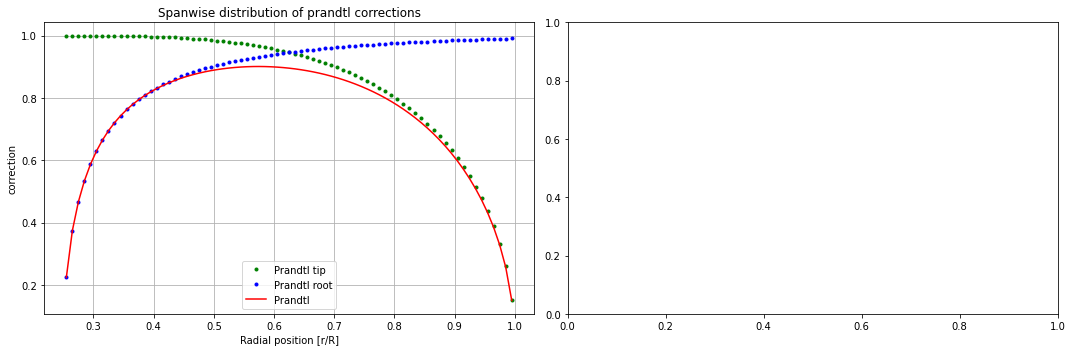

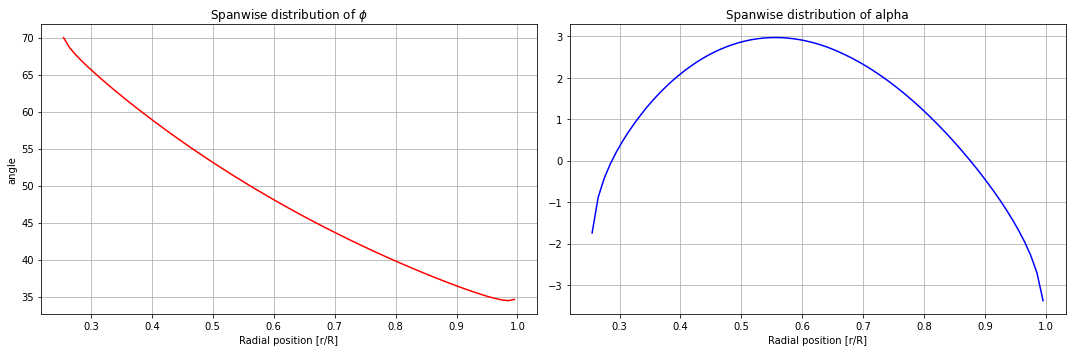

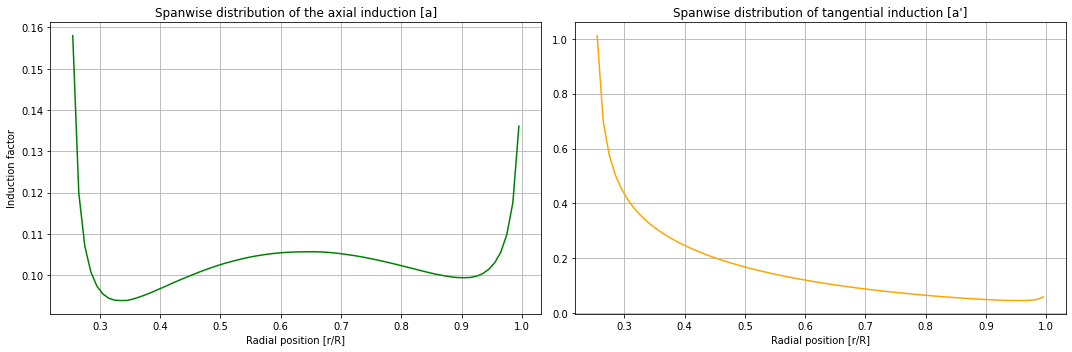

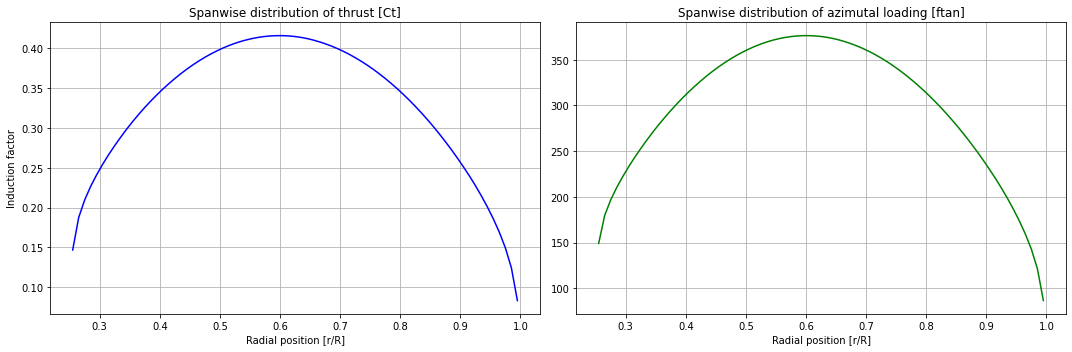

In [364]:

# %%
# Generate some sample data

# Create prandtl tip and root plots

# Create a 2x2 plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(list_r_R, list_prandtl_tip,'.', color='green', label='Prandtl tip')
axs[0].plot(list_r_R, list_prandtl_root,'.', color='blue', label='Prandtl root')
axs[0].plot(list_r_R, list_prandtl, color='red', label='Prandtl')
axs[0].set_title('Spanwise distribution of prandtl corrections')
axs[0].grid(True)
axs[0].set_xlabel('Radial position [r/R]')
axs[0].set_ylabel('correction')
axs[0].legend()

# Adjust layout to prevent overlap of titles
plt.tight_layout()

# Show the plot
plt.show()

# Create a 2x2 plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot data in each subplot
axs[0].plot(list_r_R, list_inflow_angle, color='red')
axs[0].set_title('Spanwise distribution of $\phi$')
axs[0].grid(True)
axs[0].set_xlabel('Radial position [r/R]')
axs[0].set_ylabel('angle')

axs[1].plot(list_r_R, list_alpha, color='blue')
axs[1].set_title('Spanwise distribution of alpha')
axs[1].grid(True)
axs[1].set_xlabel('Radial position [r/R]')

# Adjust layout to prevent overlap of titles
plt.tight_layout()

# Show the plot
plt.show()

# %%
# Create a 2x2 plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(list_r_R, list_a, color='green')
axs[0].set_title('Spanwise distribution of the axial induction [a]')
axs[0].grid(True)
axs[0].set_xlabel('Radial position [r/R]')
axs[0].set_ylabel('Induction factor')

axs[1].plot(list_r_R, list_aline, color='orange')
axs[1].set_title("Spanwise distribution of tangential induction [a']")
axs[1].grid(True)
axs[1].set_xlabel('Radial position [r/R]')

# Adjust layout to prevent overlap of titles
plt.tight_layout()

# Show the plot
plt.show()

# %%
# Create a 2x2 plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(list_r_R, list_ct, color='blue')
axs[0].set_title('Spanwise distribution of thrust [Ct]')
axs[0].grid(True)
axs[0].set_xlabel('Radial position [r/R]')
axs[0].set_ylabel('Induction factor')

axs[1].plot(list_r_R, list_ftan, color='green')
axs[1].set_title("Spanwise distribution of azimutal loading [ftan]")
axs[1].grid(True)
axs[1].set_xlabel('Radial position [r/R]')

# Adjust layout to prevent overlap of titles
plt.tight_layout()

# Show the plot
plt.show()

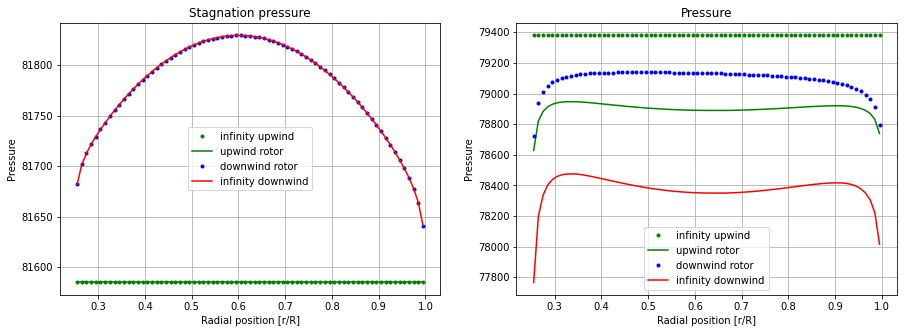

In [365]:
C_bernoulli = P_s + 0.5 * density * U0**2
list_P1s = []
list_P2s = []
list_P3s = []
list_P4s = []
list_P1 = []
list_P2 = []
list_P3 = []
list_P4 = []

for i in range(len(list_a)):
    P_1s = C_bernoulli
    P_1 = P_s
    P_2s = C_bernoulli 
    P_2 = C_bernoulli - 0.5 * density * (U0 * (1 + list_a[i])) ** 2 #add tangential velocity? 
    P_3s = list_ftan[i]/(np.pi * (R ** 2)) + P_2s
    P_3 = list_ftan[i] / (np.pi * (R ** 2)) + P_2
    P_4s = P_3s
    P_4 = C_bernoulli - 0.5 * density * (U0 * (1 + 2 * list_a[i])) ** 2
    list_P1s.append(P_1s)
    list_P2s.append(P_2s)
    list_P3s.append(P_3s)
    list_P4s.append(P_4s)
    list_P1.append(P_1)
    list_P2.append(P_2)
    list_P3.append(P_3)
    list_P4.append(P_4)

# %%


#plots stagnation pressure
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(list_r_R, list_P1s,'.', color='green', label='infinity upwind')
axs[0].plot(list_r_R, list_P2s, color='green', label='upwind rotor')
axs[0].plot(list_r_R, list_P3s,'.', color='blue', label='downwind rotor')
axs[0].plot(list_r_R, list_P4s, color='red', label='infinity downwind')
axs[0].set_title('Stagnation pressure')
axs[0].grid(True)
axs[0].set_xlabel('Radial position [r/R]')
axs[0].set_ylabel('Pressure')
axs[0].legend()

axs[1].plot(list_r_R, list_P1,'.', color='green', label='infinity upwind')
axs[1].plot(list_r_R, list_P2, color='green', label='upwind rotor')
axs[1].plot(list_r_R, list_P3,'.', color='blue', label='downwind rotor')
axs[1].plot(list_r_R, list_P4, color='red', label='infinity downwind')
axs[1].set_title('Pressure')
axs[1].grid(True)
axs[1].set_xlabel('Radial position [r/R]')
axs[1].set_ylabel('Pressure')
axs[1].legend()

plt.show()

In [366]:
#Gauerts theory for yaw

def Vortexangle(a,yaw_angle):
    #Function for Vortex angle
    return (0.6*a + 1)*yaw_angle

#def CT_yaw(a,yaw_angle):
#    return 4*a*np.sqrt(1-a*(2*np.cos(yaw_angle)-a))

def Urel(U0,yaw_angle,u0):
    return np.sqrt((U0*cos(yaw_angle)-u0)**2+(U0*np.sin(yaw_angle))**2)

def a_yaw(a,Vortexangle,r_Rconsidered,azimuthalangle):
    return a*(1 - 2*np.tan(Vortexangle/2)*r_Rconsidered*np.sin(azimuthalangle))

In [367]:
#Performing the calculation for each division by changing the Azimuthal angle and r_R position

AZangle = np.arange(0, 360 , 1) # Divided the Azimuthal angle for 360 divisions

A = [] #Array for new a values
C = [] #Array for new CT values

for i in AZangle:
    adata=[]
    CTdata=[]
    for k in range(len(list_r_R)):
        VAngle = Vortexangle(list_a[k],yaw_angle)
        azimuthalangle=i*(np.pi/180)
        a_y = a_yaw(list_a[k],VAngle,list_r_R[k],azimuthalangle)
        adata.append(a_y)
        CTtemp = CTfunction(a_y)
        CTdata.append(CTtemp)
    A.append(adata)
    C.append(CTdata)

#print(np.array(A))
#print(np.transpose(np.array(A)))

#print(len(np.array(A)))
#print(len(np.array(A)[1]))


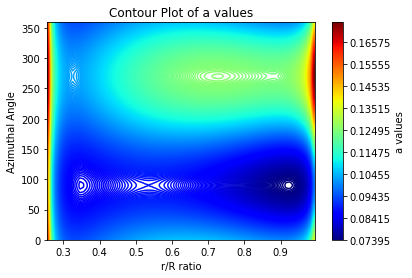

In [368]:
# Contour plot for a values for r_R values and Azimuthal angle values
x = np.array(list_r_R)
y = AZangle
z = np.array(A)

X, Y = np.meshgrid(x, y)

plt.contour(X, Y, z,cmap='jet', levels = 1000)
plt.xlabel('r/R ratio')
plt.ylabel('Azimuthal Angle')
plt.title('Contour Plot of a values')
plt.colorbar(label='a values')
plt.show()

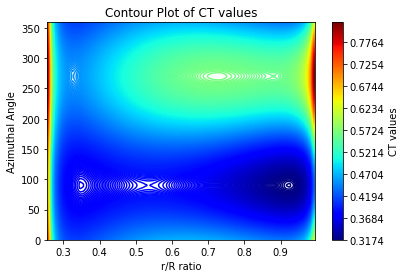

In [369]:
# Contour plot for CT values for r_R values and Azimuthal angle values
x = np.array(list_r_R)
y = AZangle
z = np.array(C)

X, Y = np.meshgrid(x, y)

plt.contour(X, Y, z,cmap='jet', levels = 1000)
plt.xlabel('r/R ratio')
plt.ylabel('Azimuthal Angle')
plt.title('Contour Plot of CT values')
plt.colorbar(label='CT values')
plt.show()

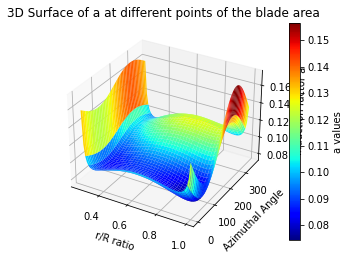

In [370]:
# 3D plot for a values for r_R and Azimuthal angle values

import matplotlib.pyplot as plt
import numpy as np

# Your data
x = np.array(list_r_R)
y = np.array(AZangle)
z = np.array(A)

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, z, cmap='jet')

# Labels and title
ax.set_xlabel('r/R ratio')
ax.set_ylabel('Azimuthal Angle')
ax.set_zlabel('Induction factor a')
ax.set_title('3D Surface of a at different points of the blade area')

# Colorbar
fig.colorbar(surf, label='a values')

plt.show()

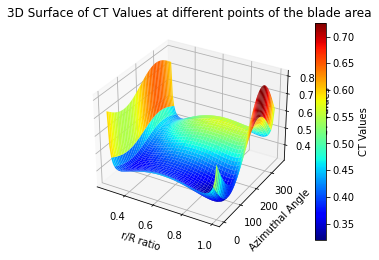

In [371]:
# 3D plot for a values for r_R and Azimuthal angle values

import matplotlib.pyplot as plt
import numpy as np

# Your data
x = np.array(list_r_R)
y = np.array(AZangle)
z = np.array(C)

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, z, cmap='jet')

# Labels and title
ax.set_xlabel('r/R ratio')
ax.set_ylabel('Azimuthal Angle')
ax.set_zlabel('CT Values')
ax.set_title('3D Surface of CT Values at different points of the blade area')

# Colorbar
fig.colorbar(surf, label='CT Values')

plt.show()

[-26.52683806946324, -28.79763821792807, -28.68452380952381, -27.52098127824403, -25.580912863070537, -22.961876832844574, -19.776061776061777, -16.037126715092814, -11.845637583892616, -7.265624999999999, -2.3235031277926717, 2.891125343092406, 8.338001867413633, 13.937381404174573, 19.644572526416905, 25.39728682170543, 31.110029211295036, 36.770731707317076, 42.26874391431353, 47.63336566440349, 52.74302213666988, 57.64537654909438, 62.25988700564972, 66.61095636025999, 70.63013698630137, 74.2831541218638, 77.63827919227391, 80.62660944206009, 83.23283082077053, 85.54285714285714, 87.4126984126984, 88.93682588597844, 90.134428678118, 90.9393063583815, 91.44553072625699, 91.55555555555554, 91.35538261997407, 90.81670822942645, 89.97007779772592, 88.79587155963303, 87.28070175438597, 85.50785340314137, 83.41317365269461, 80.95396298054106, 78.00721370604148, 74.47792869269948, 70.69184890656064, 66.5938541281007, 62.240493319630005, 57.69448818897638, 52.983615981603904, 48.2109375, 4

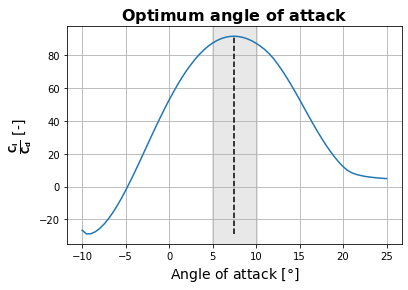

In [372]:

cl_cd = list(np.array(cl_polar)/np.array(cd_polar))
print(cl_cd)
AoA_operating_i = cl_cd.index(max(cl_cd))
optimum_alpha = alpha_polar[AoA_operating_i]
print(optimum_alpha)

percentage = 34

x_start = optimum_alpha * (1 - percentage/100)
x_end = optimum_alpha * (1 + percentage/100)
y_start = 0
y_end = max(cl_cd)

# Highlight the region


plt.plot(alpha_polar, cl_cd)
plt.title(r"$\bf{Optimum\ angle\ of\ attack}$", fontsize=16, fontstyle='italic')
plt.xlabel(r"Angle of attack [$\degree$]", fontsize=14)
plt.ylabel(r"$\bf{\frac{C_l}{C_d}}$ [-]", fontsize=14)
plt.vlines(alpha_polar[AoA_operating_i], ymin= min(cl_cd), ymax= max(cl_cd), linestyle='--', colors= "black")
plt.axvspan(x_start, x_end, color='lightgray', alpha=0.5)
#plt.axhspan(y_start, y_end, color='lightgray', alpha=0.5)
plt.grid(True)
plt.show()




<script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>
The propeller should operate at an certain flight condition which results in a thrust requirement. The lift on the propeller is the source of this thrust and should therefore be maximized. However, the drag coefficient should also be considered in the optimilisation process. The equations for lift and drag are represented in figure \ref
\begin{equation}
  L = \frac{1}{2} \rho v^2 c * c_l
\end{equation}

\begin{equation}
  D = \frac{1}{2} \rho v^2 c * c_d
\end{equation}

The dynamic pressure is a result of the operating condition and, therefore, it can not be adjusted. However, the chord and lift/drag coeffient are parameters that can be used as a designer. Lets consider the product of $c*c_l = B$ and this is a constant. Now substitute for the chord in the drag formula and minimize. 

\begin{equation}
  minimize(D = \frac{1}{2} \rho v^2  \frac{c_d}{c_l} B)
\end{equation}

This is the same as optimizing .. since B is constant and the other conditions are operational conditions.
\begin{equation}
  optimize( \frac{c_l}{c_d})
\end{equation}

The optimum characteristcs of the propeller is therefore obtained near the region corresponding with an angle of attack where the  $\frac{c_l}{c_d} is maximized. In figure.. can be concluded that the region between 5 $\deg$ and 10 $\deg$. The angle of attack is a result of the advance ratio. The angle between the inflow velocity and the rotational velocity 

The optimum operating point for the propeller is thus defined by the advance ratio where the most portion of favourable angle of attacks can be found. Furthermore, the designer of the propeller can increase the chord length at regions where the optimum angle of attack can be found for the design advance ratio. This will result in larger airfoil sections at hight cl/cd ratios benefiting from the optimum operational point of the airfoil. Designers have control over the design optimum advance ratio by setting the blade pitch. The distribution of the angle of attack over the chord can also be controlled by introducing blade twist. 


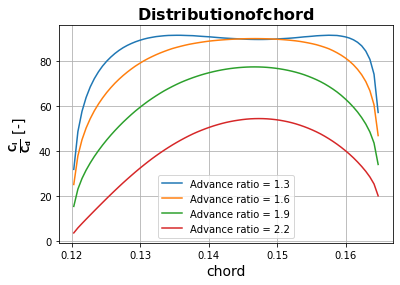

In [373]:
#[list_a, list_aline, list_ct, list_r_R, list_inflow_angle, list_alpha, list_ftan, list_cl_cd, list_chord]

list_J = []
js = np.arange(1.3, 2.4, .3)
for J in js:
    list_J.append(BEM(7))

for i in range(len(list_J)):
    plt.plot(list_J[i][8], list_J[i][7], label = f"Advance ratio = {np.round(js[i], 1)}")
plt.title(r"$\bf{Distribution of chord}$", fontsize=16, fontstyle='italic')
plt.xlabel(r'chord', fontsize=14)
plt.ylabel(r"$\bf{\frac{C_l}{C_d}}$ [-]", fontsize=14)
#plt.axhspan(y_start, y_end, color='lightgray', alpha=0.5)
plt.grid(True)
plt.legend()
plt.show()

